<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/08_finite_mdp_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**.
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

In [ ]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !ln -s /content/drive/MyDrive/ai6g_files/files_08_mdp/* ./files_08_mdp
    !pip install -r requirements.txt

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**. *Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

## User Scheduling scenario


In the User Scheduling scenario, the state is defined as the position of the two users and their buffers occupancy and the action is to select one of the two users.
Given that Nu=2 and G=6, there are S= (G²)*(G²)*(B+1)*Nu states, where G is the grid dimension, Nu is the number of users and B is the buffer size, and A = 2 actions. 

In [1]:
%cd files_08_mdp

/home/rebecca/SBrT/ai6g/files_08_mdp


In [2]:
import numpy as np
import itertools
import sys
from src.FiniteMDP import FiniteMDP
from numpy.random import randint
from src.createData import *
from src.NextStateProbabilitiesEnv import NextStateProbabilitiesEnv


class UserSchedulingEnv(NextStateProbabilitiesEnv):

    def __init__(self):
        self.ues_pos_prob, self.channel_spectral_efficiencies, self.ues_valid_actions = self.read_external_files()
        self.actions_move = np.array([
            [-1, 0],
            [0, 1],
            [1, 0],
            [0, -1],
            [0, 0],
        ])  # Up, right, down, left, stay
        self.Nu = 2
        nextStateProbability, rewardsTable = self.createEnvironment()
        super().__init__(nextStateProbability, rewardsTable)


    def read_external_files(self):
        ue0_file = np.load("./mobility_ue0.npz")
        ue0 = ue0_file.f.matrix_pos_prob
        ue0_valid = ue0_file.f.pos_actions_prob
        ue1_file = np.load("./mobility_ue1.npz")
        ue1 = ue1_file.f.matrix_pos_prob
        ue1_valid = ue1_file.f.pos_actions_prob
        capacity = np.load("./spec_eff_matrix.npz")
        capacity = capacity.f.spec_eff_matrix


        return ([ue0,ue1],capacity, [ue0_valid,ue1_valid])

    def createEnvironment(self):
    
        G = 6 #grid dimension
        B = 3  # buffer size
        Nu = 2 #number of users
        num_incoming_packets_per_time_slot = 2

        print(" States = ", (G**2)*(G**2)*((B+1)**Nu))

        indexGivenActionDictionary, actionGivenIndexList = createActionsDataStructures()
        A = len(actionGivenIndexList)

        indexGivenStateDictionary, stateGivenIndexList = createStatesDataStructures()
        S = len(stateGivenIndexList)

        nextStateProbability = np.zeros((S, A, S))
        rewardsTable = np.zeros((S, A, S))
        for s in range(S):
            #current state:
            currentState = stateGivenIndexList[s]
            #interpret the state
            (all_positions, buffers_occupancy) = currentState 
            for a in range(A):                
                currentAction = actionGivenIndexList[a]
                #in this case, the action is the user
                chosen_user = a 
                #get the channels spectral efficiency (SE)
                chosen_user_position = all_positions[chosen_user]
                #transmitted packets 
                se = self.channel_spectral_efficiencies[chosen_user_position[0],chosen_user_position[1]]
                #transmitted packets 
                transmitRate = se 

                new_buffer = np.array(buffers_occupancy)
                #decrement buffer of chosen user
                new_buffer[chosen_user] -= transmitRate 
                new_buffer[new_buffer<0] = 0
                #arrival of new packets
                new_buffer += num_incoming_packets_per_time_slot 

                #check if overflow
                #in case positive, limit the buffers to maximum capacity
                number_dropped_packets = new_buffer - B
                number_dropped_packets[number_dropped_packets<0] = 0

                #saturate buffer levels
                new_buffer -= number_dropped_packets

                buffers_occupancy=tuple(new_buffer) #convert to tuple to compose state

                # calculate rewards
                sumDrops = np.sum(number_dropped_packets)
                r = -sumDrops

                for ue1_action in np.arange(5):
                    for ue2_action in np.arange(5):
                        prob_ue1_action = self.ues_valid_actions[0][all_positions[0][0], all_positions[0][1]][ue1_action]
                        prob_ue2_action = self.ues_valid_actions[1][all_positions[1][0], all_positions[1][1]][ue2_action]
                        if prob_ue1_action!=0 and prob_ue2_action!=0:
                            #calculate nextState
                            new_position_ue1 = np.array(all_positions[0]) + self.actions_move[ue1_action]
                            new_position_ue2 = np.array(all_positions[1]) + self.actions_move[ue2_action]
                            new_position = ((new_position_ue1[0],new_position_ue1[1]), (new_position_ue2[0],new_position_ue2[1]))
                            nextState = (new_position, buffers_occupancy)

                            # probabilistic part: consider the user mobility
                            nextStateIndice = indexGivenStateDictionary[nextState]
                            #take in account mobility
                            nextStateProbability[s, a, nextStateIndice] = prob_ue1_action * prob_ue2_action
                            rewardsTable[s, a, nextStateIndice] = r
        self.indexGivenActionDictionary = indexGivenActionDictionary
        self.actionGivenIndexList = actionGivenIndexList
        self.indexGivenStateDictionary = indexGivenStateDictionary
        self.stateGivenIndexList = stateGivenIndexList

        return nextStateProbability, rewardsTable

       
    def enable_rendering(self):
        self.should_render = True
        from render_user_scheduling import Scheduling_RL_render
        self.schedule_render =  Scheduling_RL_render()
    
    def render(self):
        self.schedule_render.render()

    def close (self):
        pass
    
    def reset(self):
        """
        Reset the state of the environment and returns an initial observation.
        Returns
        -------
        observation (object): the initial observation of the space.
        """
        show_debug_info = True
        
        indexGivenStateDictionary, stateGivenIndexList = createStatesDataStructures()
        self.currentIteration = 0
        self.episode_return = 0

        #In the beginning, choose user actions randomly
        a = randint(0,4,size=(self.Nu,))
        self.actions_move = a

        total_states = len(stateGivenIndexList)

        #Chose a state out of all the possible ones
        s = randint(0, total_states)
        self.current_state_index = stateGivenIndexList[s]
       
        return total_states
    


if __name__ == '__main__':

    env = UserSchedulingEnv()
 

 States =  20736


### Bellman Algorithm 

In [ ]:
import numpy as np
from src.FiniteMDP import FiniteMDP

episodes = np.arange(900, 1000)
n_steps = 1000
se = np.load("./spec_eff_matrix.npz")
se = se.f.spec_eff_matrix
env = UserSchedulingEnv()
file_states_actions = np.load("./states_actions.npz", allow_pickle=True)
indexGivenStateDictionary = file_states_actions.f.indexGivenStateDictionary.item()
file_optimal_values = np.load("./optimal_values.npz")
optimal_policy = file_optimal_values.f.optimal_policy
mdp = FiniteMDP(env)

rewards = np.zeros((len(episodes), n_steps))
n_users = 2


buffer_size = 3
num_incoming_packets_per_time_slot = 2
rewards = np.zeros((len(episodes), n_steps))
for n_episode, episode in enumerate(episodes):
	file_pos = np.load("./mobility_traces/ep{}.npz".format(episode))
	for step in np.arange(n_steps):
		print("Episode {}, step {}".format(n_episode, step))
		pos_ues = ((file_pos.f.ue1[step][0], file_pos.f.ue1[step][1]), (file_pos.f.ue2[step][0], file_pos.f.ue2[step][1]))
		if step == 0:
			buffers = np.array([0, 0])
		state = (pos_ues, tuple(buffers))
		prob_actions = optimal_policy[indexGivenStateDictionary[state]]
		
		#in this case, the action is the user
		chosen_user = np.random.choice(2, p=prob_actions) 
		number_dropped_packets = 0
		for user in np.arange(n_users):
			if user == chosen_user:
				#get the channels spectral efficiency (SE)
				chosen_user_position = pos_ues[user]

				se_chosen_ue = se[int(chosen_user_position[0]),int(chosen_user_position[1])]
				#based on selected (chosen) user, update its buffer
				transmitRate = se_chosen_ue #transmitted packets 
				buffers[chosen_user] -= transmitRate #decrement buffer of chosen user
				buffers[buffers<0] = 0
			buffers[user] += num_incoming_packets_per_time_slot #arrival of new packets

			#check if overflow
			#in case positive, limit the buffers to maximum capacity
			number_dropped_packets = buffers[user] - buffer_size
			number_dropped_packets = 0 if number_dropped_packets < 0 else number_dropped_packets

			#saturate buffer levels
			buffers[user] = buffer_size if buffers[user]>buffer_size else buffers[user]

			# calculate rewards
			rewards[n_episode, step] -= number_dropped_packets

### Integer Programming Algorithm 

In [3]:
def IP_algorithm( n_steps, should_render=False):
	

	episodes = np.arange(900, 1000)
	num_incoming_packets_per_time_slot = 2
	buffer_size = 3
	n_users = 2

	se = np.load("./spec_eff_matrix.npz")
	se = se.f.spec_eff_matrix

	rewards = np.zeros((len(episodes), n_steps))

	actions = np.load("./actions_opt.npz")
	actions = actions.f.actions


	rewards = np.zeros((len(episodes), n_steps))
	for n_episode, episode in enumerate(episodes):
		file_pos = np.load("./mobility_traces/ep{}.npz".format(episode))
		for step in np.arange(n_steps):
			print("Episode {}, step {}".format(n_episode, step))
			pos_ues = ((file_pos.f.ue1[step][0], file_pos.f.ue1[step][1]), (file_pos.f.ue2[step][0], file_pos.f.ue2[step][1]))
			if step == 0:
				buffers = np.array([0, 0])
			state = (pos_ues, tuple(buffers))
		
			chosen_user = int(actions[n_episode, step])
			number_dropped_packets = 0
			for user in np.arange(n_users):
				if user == chosen_user:

					#get the channels spectral efficiency (SE)
					chosen_user_position = pos_ues[user]
					#based on selected (chosen) user, update its buffer
					se_chosen_ue = se[int(chosen_user_position[0]),int(chosen_user_position[1])]
					
					#transmitted packets 
					transmitRate = se_chosen_ue 
					#decrement buffer of chosen user
					buffers[chosen_user] -= transmitRate 
					buffers[buffers<0] = 0
					#arrival of new packets
				buffers[user] += num_incoming_packets_per_time_slot 

				#check if overflow
				#in case positive, limit the buffers to maximum capacity
				number_dropped_packets = buffers[user] - buffer_size
				number_dropped_packets = 0 if number_dropped_packets < 0 else number_dropped_packets

				#saturate buffer levels
				buffers[user] = buffer_size if buffers[user]>buffer_size else buffers[user]

				# calculate rewards
				rewards[n_episode, step] -= number_dropped_packets

				if should_render:
					from src.render_user_scheduling import Scheduling_RL_render
					schedule_render = Scheduling_RL_render()	
					schedule_render.set_positions(pos_ues, chosen_user)
					schedule_render.render()
	
	
	env = UserSchedulingEnv()
	env.reset()


if __name__ == '__main__':
	IP_algorithm(n_steps=10, should_render = False)


Episode 0, step 0
Episode 0, step 1
Episode 0, step 2
Episode 0, step 3
Episode 0, step 4
Episode 0, step 5
Episode 0, step 6
Episode 0, step 7
Episode 0, step 8
Episode 0, step 9
Episode 1, step 0
Episode 1, step 1
Episode 1, step 2
Episode 1, step 3
Episode 1, step 4
Episode 1, step 5
Episode 1, step 6
Episode 1, step 7
Episode 1, step 8
Episode 1, step 9
Episode 2, step 0
Episode 2, step 1
Episode 2, step 2
Episode 2, step 3
Episode 2, step 4
Episode 2, step 5
Episode 2, step 6
Episode 2, step 7
Episode 2, step 8
Episode 2, step 9
Episode 3, step 0
Episode 3, step 1
Episode 3, step 2
Episode 3, step 3
Episode 3, step 4
Episode 3, step 5
Episode 3, step 6
Episode 3, step 7
Episode 3, step 8
Episode 3, step 9
Episode 4, step 0
Episode 4, step 1
Episode 4, step 2
Episode 4, step 3
Episode 4, step 4
Episode 4, step 5
Episode 4, step 6
Episode 4, step 7
Episode 4, step 8
Episode 4, step 9
Episode 5, step 0
Episode 5, step 1
Episode 5, step 2
Episode 5, step 3
Episode 5, step 4
Episode 5,

### Comparing Integer Programming, Bellman and Deep RL algorithm performance

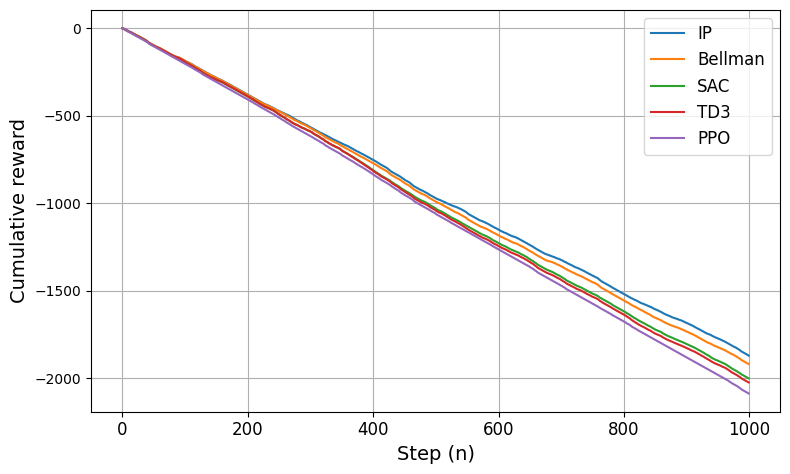

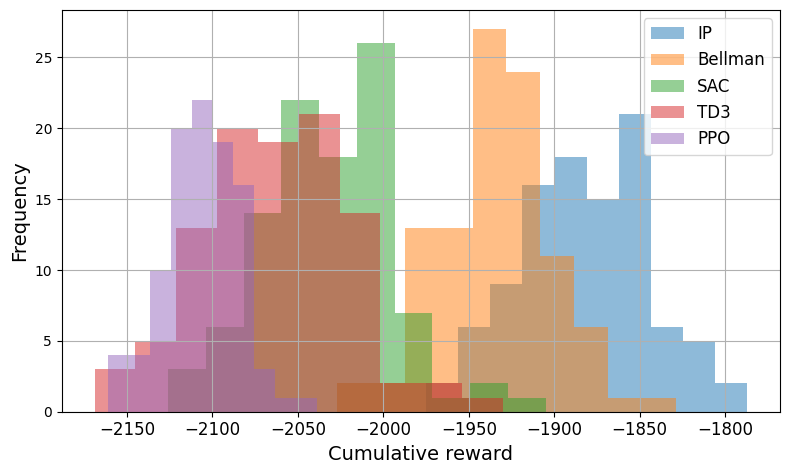

In [5]:
import matplotlib.pyplot as plt
import os
import numpy as np

reward_mdp = np.load("./hist/rewards_Bellman.npz")
reward_mdp = reward_mdp.f.rewards
reward_sac = np.load("./hist/rewards_sac.npz")
reward_sac = reward_sac.f.rewards
reward_td3 = np.load("./hist/rewards_td3.npz")
reward_td3 = reward_td3.f.rewards
reward_ppo = np.load("./hist/rewards_ppo.npz")
reward_ppo = reward_ppo.f.rewards
reward_opt = np.load("./hist/rewards_IP.npz")
reward_opt = reward_opt.f.rewards

n_steps = 1000
ep_number = 99 # Equivalent to the 999 since we start at 900

# Cumulative reward episode 999
w, h = plt.figaspect(0.6)
fig = plt.figure(figsize=(w, h))
plt.xlabel("Step (n)", fontsize=14)
plt.ylabel("Cumulative reward", fontsize=14)
plt.grid()
plt.plot(np.arange(n_steps), np.cumsum(reward_opt[ep_number]), label="IP")
plt.plot(np.arange(n_steps), np.cumsum(reward_mdp[ep_number]), label="Bellman")
plt.plot(np.arange(n_steps), np.cumsum(reward_sac[ep_number]), label="SAC")
plt.plot(np.arange(n_steps), np.cumsum(reward_td3[ep_number]), label="TD3")
plt.plot(np.arange(n_steps), np.cumsum(reward_ppo[ep_number]), label="PPO")

fig.tight_layout()
plt.xticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

# Histogram
w, h = plt.figaspect(0.6)
fig = plt.figure(figsize=(w, h))
plt.xlabel("Cumulative reward", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid()
plt.hist(np.sum(reward_opt, axis=1), label="IP", alpha=0.5)
plt.hist(np.sum(reward_mdp, axis=1), label="Bellman", alpha=0.5)
plt.hist(np.sum(reward_sac, axis=1), label="SAC", alpha=0.5)
plt.hist(np.sum(reward_td3, axis=1), label="TD3", alpha=0.5)
plt.hist(np.sum(reward_ppo, axis=1), label="PPO", alpha=0.5)

fig.tight_layout()
plt.xticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()


## Authors

- [Rebecca Aben-Athar - LASSE/UFPA](https://github.com/rebeccaathar)